## 2. Vanilla GPFA

It is vanilla in the sense that it only handles trials with the same length for now.

In [2]:
%reload_ext autoreload
%autoreload 2

In [83]:
import numpy as np
import quantities as pq
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

In [84]:
from e_step import e_step
from m_step import m_step
from postprocessing import post_processing

In [19]:
# =====================
# load simulated data
# =====================

seqs = np.load('simulated_data1.npy',allow_pickle=True)

In [55]:
# ==================================
# Initialize state model parameters
# ==================================
x_dim = 2
bin_width=20.0    # in ms, this should match how we simulated the synthetic data.
tau_init=100.0
eps_init=1.0E-3
em_tol = 1.0E-3

max_iteration_num = 100
    
params_init = dict()
params_init['covType'] = 'rbf' # so far only rbf is implemented for this vanilla version
# GP timescale
# Assume binWidth is the time step size.
params_init['gamma'] = (bin_width / tau_init) ** 2 * np.ones(x_dim)
# GP noise variance
params_init['eps'] = eps_init * np.ones(x_dim)

# ========================================
# Initialize observation model parameters
# ========================================
print('Initializing parameters using factor analysis...')

y_all = np.hstack(seqs['y'])
fa = FactorAnalysis(n_components=x_dim, copy=True,
                    noise_variance_init=np.diag(np.cov(y_all, bias=True)))
fa.fit(y_all.T)
params_init['d'] = y_all.mean(axis=1)
params_init['C'] = fa.components_.T
params_init['R'] = np.diag(fa.noise_variance_)
params_init['x_dim'] = 2
params_init['tau'] = tau_init


Initializing parameters using factor analysis...


In [57]:
# =====================
# Fit model parameters
# =====================

params = params_init
for i in range(max_iteration_num):
    seqs_out, LL_i = e_step(seqs, params)
    params = m_step(seqs_out, params)

    
    # Check convergence
    if i <= 1:
        LL_base = LL_i
        LL_old = LL_i
    elif LL_i < LL_old:
        print(f"\nError: Log likelihood decreased from {LL_old:.1f} to {LL_i:.1f}")
        break
    elif (LL_i - LL_base) < (1 + em_tol) * (LL_old - LL_base):
        print(f"\nConverged after {i+1} EM iterations")
        break
    LL_old = LL_i
            


Converged after 42 EM iterations


In [86]:
# =====================
# Post processing
# =====================
params_est, seq_final = post_processing(params, seqs_out)

In [88]:
# results
groudtruth = np.load('simulated_groundtruth.npy',allow_pickle=True)

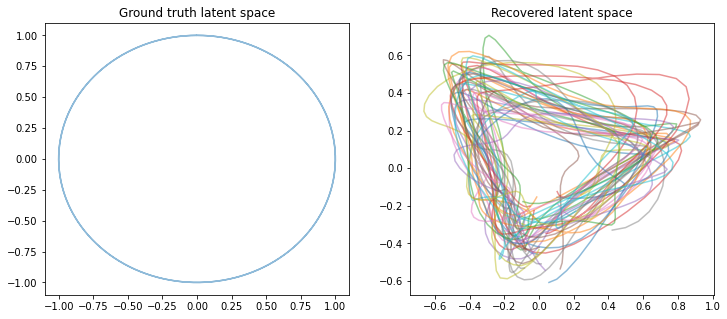

In [93]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(groudtruth[0,:], groudtruth[1,:], alpha = 0.5)
ax1.set_title("Ground truth latent space")

for n in range(len(seq_final)):
    reduced_data = seq_final["latent_variable_orth"][n]
    ax2.plot(reduced_data[0,:], reduced_data[1,:], alpha = 0.5)
    ax2.set_title("Recovered latent space")